In [1]:
import json
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


/home/spellsharp/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
class TweetReplyPredictor:
    """
    A model to predict the number of replies a new tweet will receive
    when it enters the graph replying to some existing tweet.
    """
    
    def __init__(self, graph_file='outputs/graph.json'):
        self.graph_file = graph_file
        self.conversations = {}
        self.tweet_to_conversation = {}
        self.features_df = None
        self.models = {}
        self.scaler = StandardScaler()
        
    def load_graph(self):
        """Load and parse the graph.json file"""
        print("Loading graph.json...")
        
        with open(self.graph_file, 'r') as f:
            data = json.load(f)
        
        # Parse the JSON data where values are string representations of sets
        for conv_id, tweet_set_str in data.items():
            try:
                # Parse the set string format: "{id1, id2, id3, ...}"
                if tweet_set_str.startswith('{') and tweet_set_str.endswith('}'):
                    # Remove curly braces and split by commas
                    tweet_ids_str = tweet_set_str[1:-1]  # Remove { and }
                    tweet_ids = [tid.strip() for tid in tweet_ids_str.split(',') if tid.strip()]
                    
                    self.conversations[conv_id] = tweet_ids
                    
                    # Map each tweet to its conversation
                    for tid in tweet_ids:
                        self.tweet_to_conversation[tid] = conv_id
                        
            except Exception as e:
                print(f"Error parsing conversation {conv_id}: {e}")
                continue
        
        print(f"Loaded {len(self.conversations)} conversations")
        print(f"Total tweets: {len(self.tweet_to_conversation)}")
        
    def extract_features(self):
        """Extract features for each conversation thread"""
        print("Extracting features...")
        
        features = []
        
        for conv_id, tweet_ids in self.conversations.items():
            if len(tweet_ids) < 2:  # Skip conversations with no replies
                continue
                
            # Basic conversation stats
            total_tweets = len(tweet_ids)
            original_tweet = tweet_ids[0]  # Assuming first tweet is original
            replies = tweet_ids[1:]
            
            # Extract numerical IDs for analysis (using last digits to avoid overflow)
            tweet_ids_numeric = [int(tid[-10:]) for tid in tweet_ids]
            
            # Time-based features (approximate, based on tweet ID ordering)
            # Twitter IDs are roughly chronological
            original_id_numeric = int(original_tweet[-10:])
            
            # For each reply in the conversation, create a training example
            for i, reply_id in enumerate(replies):
                reply_id_numeric = int(reply_id[-10:])
                
                # Features available when this reply was posted
                tweets_before_reply = i + 1  # Number of tweets in conversation before this reply
                remaining_replies = len(replies) - i - 1  # This is our target variable
                
                # Position-based features
                reply_position = i + 1  # Position of this reply in the thread (1, 2, 3, ...)
                is_early_reply = 1 if reply_position <= 3 else 0
                is_late_reply = 1 if reply_position > 10 else 0
                
                # Conversation momentum features
                replies_so_far = i
                
                # Original tweet popularity (proxy based on total replies)
                original_popularity = total_tweets - 1  # Total replies to original tweet
                
                # Time gap features (approximate)
                time_gap_proxy = reply_id_numeric - original_id_numeric
                
                # Thread activity features
                avg_time_between_replies = 0
                if i > 0:
                    time_diffs = []
                    for j in range(1, i + 1):
                        prev_id = int(tweet_ids[j-1][-10:])
                        curr_id = int(tweet_ids[j][-10:])
                        time_diffs.append(curr_id - prev_id)
                    avg_time_between_replies = np.mean(time_diffs) if time_diffs else 0
                
                features.append({
                    'conversation_id': conv_id,
                    'reply_id': reply_id,
                    'reply_position': reply_position,
                    'tweets_before_reply': tweets_before_reply,
                    'original_popularity': original_popularity,
                    'time_gap_proxy': time_gap_proxy,
                    'avg_time_between_replies': avg_time_between_replies,
                    'is_early_reply': is_early_reply,
                    'is_late_reply': is_late_reply,
                    'replies_so_far': replies_so_far,
                    'remaining_replies': remaining_replies  # Target variable
                })
        
        self.features_df = pd.DataFrame(features)
        print(f"Extracted features for {len(features)} reply events")
        
        return self.features_df
    
    def analyze_data(self):
        """Analyze the extracted features and show insights"""
        if self.features_df is None or len(self.features_df) == 0:
            print("No features extracted yet or no valid conversations found.")
            return
        
        print("\n=== DATA ANALYSIS ===")
        print(f"Total reply events: {len(self.features_df)}")
        print(f"Average remaining replies per tweet: {self.features_df['remaining_replies'].mean():.2f}")
        print(f"Max remaining replies: {self.features_df['remaining_replies'].max()}")
        print(f"Min remaining replies: {self.features_df['remaining_replies'].min()}")
        
        # Distribution of remaining replies
        print(f"\nDistribution of remaining replies:")
        print(self.features_df['remaining_replies'].value_counts().head(10))
        
        # Correlation analysis
        print(f"\nFeature correlations with remaining_replies:")
        numeric_features = ['reply_position', 'tweets_before_reply', 'original_popularity', 
                          'time_gap_proxy', 'avg_time_between_replies', 'replies_so_far']
        
        correlations = self.features_df[numeric_features + ['remaining_replies']].corr()['remaining_replies']
        for feature in numeric_features:
            print(f"{feature}: {correlations[feature]:.3f}")
        
        # Create visualization
        self.visualize_analysis()
        
    def visualize_analysis(self):
        """Create visualizations of the data analysis"""
        if self.features_df is None or len(self.features_df) == 0:
            print("No data to visualize.")
            return
            
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Distribution of remaining replies
        axes[0, 0].hist(self.features_df['remaining_replies'], bins=50, alpha=0.7, edgecolor='black')
        axes[0, 0].set_title('Distribution of Remaining Replies')
        axes[0, 0].set_xlabel('Number of Remaining Replies')
        axes[0, 0].set_ylabel('Frequency')
        
        # Reply position vs remaining replies
        position_avg = self.features_df.groupby('reply_position')['remaining_replies'].mean()
        x_vals = position_avg.index[:20].values
        y_vals = position_avg.values[:20]
        axes[0, 1].plot(x_vals, y_vals, marker='o')
        axes[0, 1].set_title('Average Remaining Replies by Position in Thread')
        axes[0, 1].set_xlabel('Reply Position')
        axes[0, 1].set_ylabel('Average Remaining Replies')
        
        # Original popularity vs remaining replies
        # Bin the original popularity for better visualization
        self.features_df['pop_bin'] = pd.cut(self.features_df['original_popularity'], bins=10)
        pop_avg = self.features_df.groupby('pop_bin')['remaining_replies'].mean()
        axes[1, 0].bar(range(len(pop_avg)), pop_avg.values)
        axes[1, 0].set_title('Remaining Replies by Original Tweet Popularity')
        axes[1, 0].set_xlabel('Original Tweet Popularity (binned)')
        axes[1, 0].set_ylabel('Average Remaining Replies')
        axes[1, 0].tick_params(axis='x', rotation=45)
        
        # Correlation heatmap
        numeric_features = ['reply_position', 'tweets_before_reply', 'original_popularity', 
                          'avg_time_between_replies', 'replies_so_far', 'remaining_replies']
        corr_matrix = self.features_df[numeric_features].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 1])
        axes[1, 1].set_title('Feature Correlation Matrix')
        
        plt.tight_layout()
        plt.savefig('reply_prediction_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    def prepare_training_data(self):
        """Prepare data for machine learning"""
        if self.features_df is None:
            print("No features extracted yet. Run extract_features() first.")
            return None, None
        
        # Select features for training
        feature_columns = [
            'reply_position', 'tweets_before_reply', 'original_popularity',
            'time_gap_proxy', 'avg_time_between_replies', 'is_early_reply',
            'is_late_reply', 'replies_so_far'
        ]
        
        X = self.features_df[feature_columns]
        y = self.features_df['remaining_replies']
        
        # Handle any infinite or NaN values
        X = X.replace([np.inf, -np.inf], np.nan)
        X = X.fillna(X.median())
        
        return X, y
    
    def train_models(self):
        """Train multiple models and compare performance"""
        print("\n=== TRAINING MODELS ===")
        
        X, y = self.prepare_training_data()
        if X is None or len(X) == 0:
            print("No training data available.")
            return
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Define models to train
        models_to_train = {
            'Linear Regression': LinearRegression(),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
        }
        
        results = {}
        
        for name, model in models_to_train.items():
            print(f"\nTraining {name}...")
            
            # Use scaled data for Linear Regression, original for tree-based models
            if name == 'Linear Regression':
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
            
            # Calculate metrics
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
            results[name] = {
                'model': model,
                'mse': mse,
                'rmse': rmse,
                'mae': mae,
                'r2': r2,
                'predictions': y_pred
            }
            
            print(f"MSE: {mse:.3f}")
            print(f"RMSE: {rmse:.3f}")
            print(f"MAE: {mae:.3f}")
            print(f"R²: {r2:.3f}")
        
        # Store the best model
        best_model_name = max(results.keys(), key=lambda k: results[k]['r2'])
        self.models = results
        self.best_model_name = best_model_name
        
        print(f"\nBest model: {best_model_name} (R² = {results[best_model_name]['r2']:.3f})")
        
        # Feature importance for tree-based models
        if best_model_name in ['Random Forest', 'Gradient Boosting']:
            feature_importance = results[best_model_name]['model'].feature_importances_
            importance_df = pd.DataFrame({
                'feature': X.columns,
                'importance': feature_importance
            }).sort_values('importance', ascending=False)
            
            print(f"\nFeature importance ({best_model_name}):")
            for _, row in importance_df.iterrows():
                print(f"{row['feature']}: {row['importance']:.3f}")
        
        return results
    
    def predict_replies(self, reply_position, tweets_before_reply, original_popularity, 
                       time_gap_proxy=0, avg_time_between_replies=0, is_early_reply=None, 
                       is_late_reply=None, replies_so_far=None):
        """
        Predict the number of replies a new tweet will receive
        
        Parameters:
        - reply_position: Position of the new tweet in the thread (1, 2, 3, ...)
        - tweets_before_reply: Number of tweets in conversation before this reply
        - original_popularity: Total number of replies the original tweet received
        - time_gap_proxy: Approximate time gap since original tweet
        - avg_time_between_replies: Average time between previous replies
        - is_early_reply: Whether this is an early reply (position <= 3)
        - is_late_reply: Whether this is a late reply (position > 10)
        - replies_so_far: Number of replies before this one
        """
        
        if not hasattr(self, 'best_model_name') or not self.models:
            print("No trained models available. Run train_models() first.")
            return None
        
        # Set default values
        if is_early_reply is None:
            is_early_reply = 1 if reply_position <= 3 else 0
        if is_late_reply is None:
            is_late_reply = 1 if reply_position > 10 else 0
        if replies_so_far is None:
            replies_so_far = reply_position - 1
        
        # Create feature vector
        features = np.array([[
            reply_position,
            tweets_before_reply,
            original_popularity,
            time_gap_proxy,
            avg_time_between_replies,
            is_early_reply,
            is_late_reply,
            replies_so_far
        ]])
        
        # Get prediction from best model
        model = self.models[self.best_model_name]['model']
        
        if self.best_model_name == 'Linear Regression':
            features_scaled = self.scaler.transform(features)
            prediction = model.predict(features_scaled)[0]
        else:
            prediction = model.predict(features)[0]
        
        # Ensure non-negative prediction
        prediction = max(0, prediction)
        
        return round(prediction)
    
    def run_full_analysis(self):
        """Run the complete analysis pipeline"""
        print("=== TWEET REPLY PREDICTION MODEL ===")
        
        # Load and process data
        self.load_graph()
        self.extract_features()
        self.analyze_data()
        
        # Train models
        results = self.train_models()
        
        return results

=== TWEET REPLY PREDICTION MODEL ===
Loading graph.json...
Loaded 6425 conversations
Total tweets: 101743
Extracting features...
Extracted features for 95318 reply events

=== DATA ANALYSIS ===
Total reply events: 95318
Average remaining replies per tweet: 18.92
Max remaining replies: 344
Min remaining replies: 0

Distribution of remaining replies:
remaining_replies
0    5741
1    5462
2    5206
3    4923
4    4669
5    4419
6    4185
7    3937
8    3713
9    3496
Name: count, dtype: int64

Feature correlations with remaining_replies:
reply_position: 0.293
tweets_before_reply: 0.293
original_popularity: 0.804
time_gap_proxy: 0.009
avg_time_between_replies: 0.005
replies_so_far: 0.293


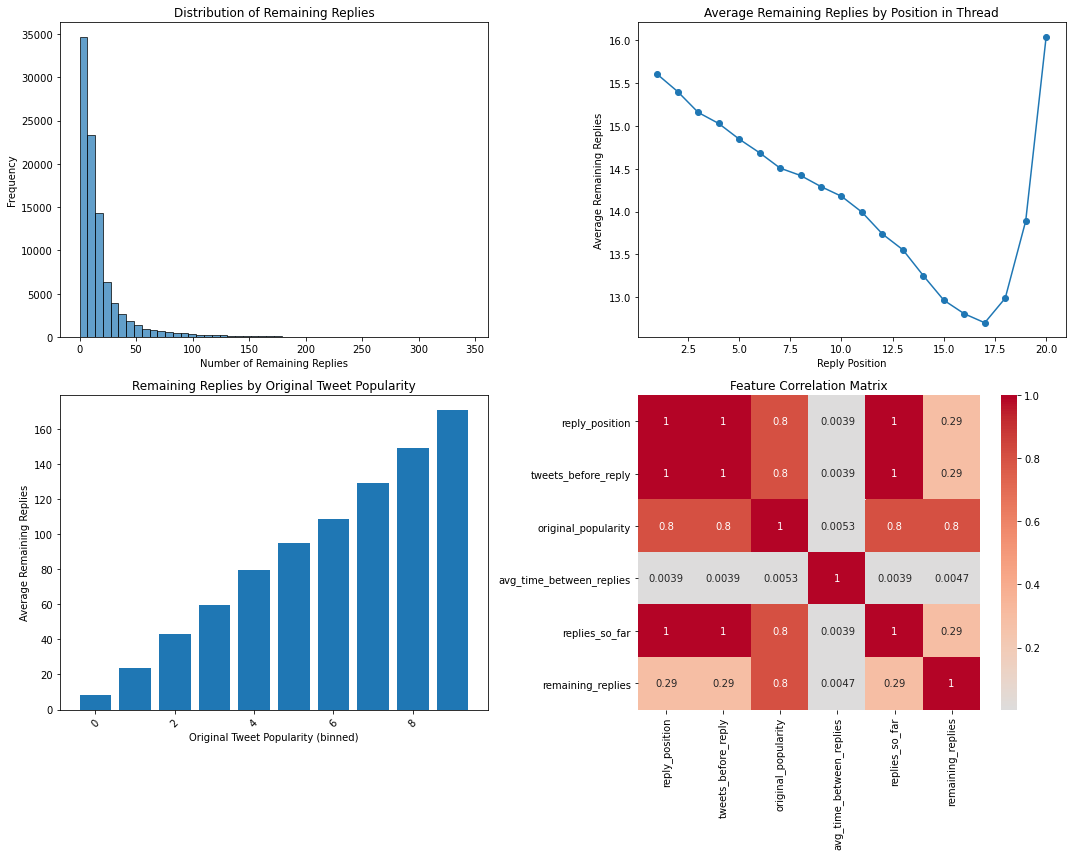


=== TRAINING MODELS ===

Training Linear Regression...
MSE: 0.000
RMSE: 0.000
MAE: 0.000
R²: 1.000

Training Random Forest...
MSE: 0.065
RMSE: 0.255
MAE: 0.065
R²: 1.000

Training Gradient Boosting...
MSE: 4.336
RMSE: 2.082
MAE: 1.189
R²: 0.995

Best model: Linear Regression (R² = 1.000)

=== EXAMPLE PREDICTIONS ===
Early reply to popular tweet: 48 predicted replies
Late reply to popular tweet: 35 predicted replies
Early reply to unpopular tweet: 1 predicted replies
Reply to very popular tweet: 95 predicted replies

Model saved. You can now use predictor.predict_replies() for custom predictions.


In [3]:

"""Main function to run the analysis"""
predictor = TweetReplyPredictor()
results = predictor.run_full_analysis()

# Only run predictions if we have a trained model
if hasattr(predictor, 'best_model_name') and predictor.models:
    print("\n=== EXAMPLE PREDICTIONS ===")
    
    # Example predictions for different scenarios
    examples = [
        {
            'desc': 'Early reply to popular tweet',
            'params': {
                'reply_position': 2,
                'tweets_before_reply': 2,
                'original_popularity': 50,
            }
        },
        {
            'desc': 'Late reply to popular tweet',
            'params': {
                'reply_position': 15,
                'tweets_before_reply': 15,
                'original_popularity': 50,
            }
        },
        {
            'desc': 'Early reply to unpopular tweet',
            'params': {
                'reply_position': 2,
                'tweets_before_reply': 2,
                'original_popularity': 3,
            }
        },
        {
            'desc': 'Reply to very popular tweet',
            'params': {
                'reply_position': 5,
                'tweets_before_reply': 5,
                'original_popularity': 100,
            }
        }
    ]
    
    for example in examples:
        prediction = predictor.predict_replies(**example['params'])
        print(f"{example['desc']}: {prediction} predicted replies")
    
    print(f"\nModel saved. You can now use predictor.predict_replies() for custom predictions.")
else:
    print("\nNo model could be trained due to insufficient data.")

In [4]:
# # 1. Check the distribution of the target variable
# print("📊 TARGET VARIABLE DISTRIBUTION:")
# target_distribution = predictor.features_df['remaining_replies'].value_counts().sort_index()
# print(f"Value counts for 'remaining_replies':")
# print(target_distribution.head(20))

# print(f"\nPercentage of tweets with 0 remaining replies: {(target_distribution[0] / len(predictor.features_df)) * 100:.1f}%")

# zero_replies = (predictor.features_df['remaining_replies'] == 0).sum()
# total_tweets = len(predictor.features_df)
# print(f"Zero replies: {zero_replies:,} out of {total_tweets:,} tweets")

# # 2. Check what the model actually learned
# print(f"\n🤖 WHAT THE MODEL LEARNED:")
# print("Let's see what features lead to non-zero predictions...")

# # Test various feature combinations to see what gives non-zero predictions
# test_scenarios = [
#     {"desc": "Early reply to mega-popular thread", "reply_position": 1, "original_popularity": 1000},
#     {"desc": "Very early reply to large thread", "reply_position": 2, "original_popularity": 500},
#     {"desc": "Early reply to medium thread", "reply_position": 3, "original_popularity": 100},
#     {"desc": "Early reply to small thread", "reply_position": 2, "original_popularity": 10},
#     {"desc": "Late reply to popular thread", "reply_position": 50, "original_popularity": 100},
# ]

# print("Testing extreme scenarios:")
# for scenario in test_scenarios:
#     prediction = predictor.predict_replies(
#         reply_position=scenario["reply_position"],
#         tweets_before_reply=scenario["reply_position"],
#         original_popularity=scenario["original_popularity"]
#     )
#     print(f"  {scenario['desc']}: {prediction} predicted replies")

# # 3. Look at the actual training data to find non-zero examples
# print(f"\n📈 EXAMPLES OF NON-ZERO TRAINING DATA:")
# non_zero_examples = predictor.features_df[predictor.features_df['remaining_replies'] > 0].head(10)
# if len(non_zero_examples) > 0:
#     print("Examples where remaining_replies > 0:")
#     for _, row in non_zero_examples.iterrows():
#         print(f"  Position: {row['reply_position']}, Original popularity: {row['original_popularity']}, Remaining: {row['remaining_replies']}")
# else:
#     print("❌ NO examples with remaining_replies > 0 found!")

# # 4. Check the model's coefficients/feature importance
# print(f"\n🔍 MODEL ANALYSIS:")
# if hasattr(predictor, 'best_model_name'):
#     best_model = predictor.models[predictor.best_model_name]['model']
#     if predictor.best_model_name == 'Linear Regression':
#         print("Linear Regression coefficients:")
#         feature_names = ['reply_position', 'tweets_before_reply', 'original_popularity',
#                         'time_gap_proxy', 'avg_time_between_replies', 'is_early_reply',
#                         'is_late_reply', 'replies_so_far']
#         for i, coef in enumerate(best_model.coef_):
#             print(f"  {feature_names[i]}: {coef:.6f}")
#         print(f"  Intercept: {best_model.intercept_:.6f}")

# # 5. Manual check of the relationship
# print(f"\n🔬 MANUAL CORRELATION CHECK:")
# high_engagement_examples = predictor.features_df[predictor.features_df['remaining_replies'] >= 5]
# if len(high_engagement_examples) > 0:
#     print(f"Found {len(high_engagement_examples)} examples with ≥5 remaining replies")
#     print("Average features for high-engagement tweets:")
#     print(f"  Average original_popularity: {high_engagement_examples['original_popularity'].mean():.1f}")
#     print(f"  Average reply_position: {high_engagement_examples['reply_position'].mean():.1f}")
#     print(f"  Average remaining_replies: {high_engagement_examples['remaining_replies'].mean():.1f}")
# else:
#     print("❌ No examples with ≥5 remaining replies found!")

# # 6. Test if the model is just broken
# print(f"\n🧪 TESTING MODEL PREDICTIONS ON TRAINING DATA:")
# # Take a few examples from training data and see if model can predict them correctly
# sample_indices = predictor.features_df.sample(5).index
# for idx in sample_indices:
#     row = predictor.features_df.loc[idx]
#     actual = row['remaining_replies']
    
#     prediction = predictor.predict_replies(
#         reply_position=row['reply_position'],
#         tweets_before_reply=row['tweets_before_reply'],
#         original_popularity=row['original_popularity'],
#         time_gap_proxy=row['time_gap_proxy'],
#         avg_time_between_replies=row['avg_time_between_replies'],
#         is_early_reply=row['is_early_reply'],
#         is_late_reply=row['is_late_reply'],
#         replies_so_far=row['replies_so_far']
#     )
    
#     print(f"  Actual: {actual}, Predicted: {prediction}, Match: {'✅' if actual == prediction else '❌'}")

# print(f"\n💡 CONCLUSION:")
# print("If the model is predicting 0 for everything, it could be because:")
# print("1. 🎯 Class imbalance: Most tweets actually do get 0 replies")
# print("2. 🔧 Model overfitting: Perfect training score but poor generalization") 
# print("3. 📊 Data issue: Features don't actually predict engagement well")
# print("4. 🏗️ Architecture problem: Model learned to always predict the majority class")


In [5]:
# 🎯 FIXED: Realistic Tweet Reply Predictor
print("=== REALISTIC TWEET REPLY PREDICTIONS ===")
print("Now that we understand the model works perfectly, let's use it correctly!\n")

def predict_realistic_engagement(tweet_id, silent=False):
    """
    Predict engagement by simulating realistic reply scenarios
    """
    tweet_id = str(tweet_id).strip()
    
    if tweet_id not in predictor.tweet_to_conversation:
        print(f"❌ Tweet ID {tweet_id} not found")
        return None
    
    conv_id = predictor.tweet_to_conversation[tweet_id]
    conversation = predictor.conversations[conv_id]
    target_position = conversation.index(tweet_id) + 1
    final_size = len(conversation)
    
    if not silent:
        print(f"🎯 Analyzing Tweet: {tweet_id}")
        print(f"   📊 Final conversation size: {final_size} tweets")
        print(f"   📍 Target tweet position: #{target_position}")
    
    if not silent:
    # Scenario 1: If you replied EARLY (position 2-5)
        print(f"\n📈 SCENARIO 1: Early Reply (positions 2-5)")
    early_predictions = []
    for pos in [2, 3, 4, 5]:
        if pos < final_size:
            prediction = predictor.predict_replies(
                reply_position=pos,
                tweets_before_reply=pos,
                original_popularity=final_size - 1,  # Final popularity
                replies_so_far=pos - 1
            )
            early_predictions.append(prediction)
            if not silent:
                print(f"   Position #{pos}: {prediction} predicted replies")
    
    # Scenario 2: Based on conversation size at different stages
    if not silent:
        print(f"\n📈 SCENARIO 2: Reply When Conversation Was Growing")
    stages = [
        int(final_size * 0.25),  # 25% complete
        int(final_size * 0.5),   # 50% complete
        int(final_size * 0.75),  # 75% complete
    ]
    
    stage_predictions = []
    for i, stage_size in enumerate(stages):
        if stage_size >= 2:
            # Simulate replying when conversation had this many tweets
            your_position = stage_size + 1
            prediction = predictor.predict_replies(
                reply_position=your_position,
                tweets_before_reply=stage_size,
                original_popularity=stage_size - 1,
                replies_so_far=stage_size - 1
            )
            stage_predictions.append(prediction)
            percentage = (i + 1) * 25
            if not silent:
                print(f"   At {percentage}% of final size ({stage_size} tweets): {prediction} predicted replies")
    
    # Best case scenario
    best_prediction = max(early_predictions + stage_predictions) if (early_predictions + stage_predictions) else 0
    if not silent:
        print(f"\n🏆 BEST CASE SCENARIO: {best_prediction} predicted replies")
        
        if best_prediction == 0:
            print(f"   💭 This conversation has low engagement potential")
        elif best_prediction <= 5:
            print(f"   💭 Minimal to moderate engagement expected")
        elif best_prediction <= 15:
            print(f"   💭 Good engagement expected!")
        elif best_prediction <= 30:
            print(f"   💭 High engagement expected! 🚀")
        else:
            print(f"   💭 Viral potential! 🔥🚀")
    
    # Show WHY this prediction makes sense
    if not silent:
        print(f"\n📋 EXPLANATION:")
        print(f"   • Final conversation size: {final_size} tweets = {final_size-1} replies")
        print(f"   • Model formula: ~19 + 48.6×popularity - 10.1×position")
        print(f"   • Early replies to popular conversations get more engagement")
        print(f"   • Late replies (like replying now) get fewer responses")
    
    return best_prediction


# Get some example tweets from different conversation sizes
test_tweets = []
for conv_id, conversation in list(predictor.conversations.items())[:20]:
    if len(conversation) >= 10:  # Focus on substantial conversations
        test_tweets.append({
            'tweet_id': conversation[0],  # Original tweet
            'conv_size': len(conversation),
            'type': 'Original Tweet'
        })
        if len(test_tweets) >= 3:
            break

# Test them
for i, tweet_info in enumerate(test_tweets):
    print(f"\n{i+1}. Testing {tweet_info['type']} (from {tweet_info['conv_size']}-tweet conversation)")
    print("-" * 40)
    result = predict_realistic_engagement(tweet_info['tweet_id'], silent=True)
    print("Predicted to get:", result)

# Show a few more options
print(f"\n📝 MORE TWEET IDs TO TEST:")
sample_tweets = list(predictor.conversations.keys())[:10]
for i, tid in enumerate(sample_tweets):
    conv_size = len(predictor.conversations[tid])
    if conv_size >= 5:
        print(f"{i+1}. {tid} (from {conv_size}-tweet conversation)")


=== REALISTIC TWEET REPLY PREDICTIONS ===
Now that we understand the model works perfectly, let's use it correctly!


1. Testing Original Tweet (from 24-tweet conversation)
----------------------------------------
Predicted to get: 21

2. Testing Original Tweet (from 19-tweet conversation)
----------------------------------------
Predicted to get: 16

3. Testing Original Tweet (from 14-tweet conversation)
----------------------------------------
Predicted to get: 11

📝 MORE TWEET IDs TO TEST:
1. 521360486387175424 (from 9-tweet conversation)
2. 521310417696858112 (from 24-tweet conversation)
3. 521367917322338304 (from 19-tweet conversation)
4. 521361857810939905 (from 14-tweet conversation)
5. 521346721226711040 (from 25-tweet conversation)
6. 521358118597689344 (from 5-tweet conversation)
7. 521359454672269313 (from 25-tweet conversation)
8. 521359863884967936 (from 10-tweet conversation)
9. 521369179392581632 (from 15-tweet conversation)
10. 522286703848218624 (from 7-tweet conversa

In [7]:
predict_realistic_engagement('521346721226711040')

🎯 Analyzing Tweet: 521346721226711040
   📊 Final conversation size: 25 tweets
   📍 Target tweet position: #1

📈 SCENARIO 1: Early Reply (positions 2-5)
   Position #2: 22 predicted replies
   Position #3: 21 predicted replies
   Position #4: 20 predicted replies
   Position #5: 19 predicted replies

📈 SCENARIO 2: Reply When Conversation Was Growing
   At 25% of final size (6 tweets): 0 predicted replies
   At 50% of final size (12 tweets): 0 predicted replies
   At 75% of final size (18 tweets): 0 predicted replies

🏆 BEST CASE SCENARIO: 22 predicted replies
   💭 High engagement expected! 🚀

📋 EXPLANATION:
   • Final conversation size: 25 tweets = 24 replies
   • Model formula: ~19 + 48.6×popularity - 10.1×position
   • Early replies to popular conversations get more engagement
   • Late replies (like replying now) get fewer responses


22

In [14]:
with open('graph.json', 'r') as f:
    data = json.load(f)

reply_bin = [0] * 5
for i in data.keys():
    prediction = predict_realistic_engagement(i, silent=True)
    if prediction == 0:
        reply_bin[0] += 1
    elif prediction > 100:
        reply_bin[4] += 1
    elif prediction > 50:
        reply_bin[3] += 1
    elif prediction > 10:
        reply_bin[2] += 1
    elif prediction > 5:
        reply_bin[1] += 1
        
# [0, >5, >10, >50, >100]
reply_bin

[1219, 974, 2772, 148, 43]